### Reasoning Model Testing and Evaluation

In [1]:
from transformers import AutoProcessor, AutoModelForImageTextToText
from peft import PeftModel
import torch
from PIL import Image
import os 

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model_id = "medgemma-4b-it-merged-cxr10k-res-merged"

processor = AutoProcessor.from_pretrained(model_id)
res_model = AutoModelForImageTextToText.from_pretrained(model_id,torch_dtype=torch.bfloat16,device_map="auto")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Loading checkpoint shards: 100%|██████████████████████████████████████████| 2/2 [00:00<00:00,  9.05it/s]


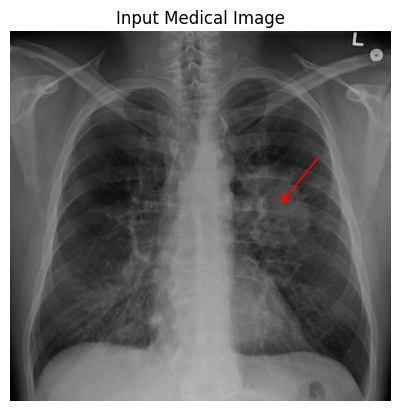

🧠 Model Output:

Step 1: Assess for Pneumothorax
No pneumothorax is identified.

Step 2: Evaluate for Pleural Effusion
No pleural effusion is present.

Step 3: Analyze Lung Fields
The lung fields are clear, with no evidence of consolidation.

Step 4: Inspect Heart Size
The heart size is normal.

Step 5: Evaluate Mediastinal Structures
The mediastinal structures are normal.

Step 6: Assess for Pulmonary Edema
No pulmonary edema is present.

Step 7: Identify Unusual Findings
An unusual appearance of the left upper lobe is noted, with a possible mass or consolidation.


In [9]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Load and display image
image = Image.open("test2.png").convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.title("Input Medical Image")
plt.show()

# Create messages for multimodal input
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Analyze this medical image and provide step-by-step findings."}
        ]
    }
]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
    add_generation_prompt=True
).to(res_model.device)

with torch.no_grad():
    outputs = res_model.generate(**inputs, max_new_tokens=200)

generated_tokens = outputs[0][inputs["input_ids"].shape[1]:]

reasoning_output_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

print("🧠 Model Output:\n")
print(reasoning_output_text)



### Summerizer Model Testing and Evaluation

In [2]:
from transformers import AutoProcessor, AutoModelForImageTextToText
from peft import PeftModel
import torch
from PIL import Image
import os 

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

model_id = "medgemma-4b-it-merged-cxr10k-sum-merged"

processor = AutoProcessor.from_pretrained(model_id)
sum_model = AutoModelForImageTextToText.from_pretrained(model_id,torch_dtype=torch.bfloat16,device_map="auto")

Loading checkpoint shards: 100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 11.02it/s]


In [10]:
import pickle
from tqdm import tqdm
import torch

with open("test_reasoning_data_cache.pkl", "rb") as f:
    test_data = pickle.load(f)

count = 100
sum_model.eval()

predictions = []
references = []

for sample in tqdm(test_data[:count]):
    # Extract reasoning and ground truth impression
    reasoning_text = sample["messages"][1]["content"][0]["text"]
    impression_text = sample["messages"][1]["content"][1]["text"]

    # Prepare chat-based prompt for summarizer
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"Summarise the following clinical reasoning into a concise radiology impression:\n\n{reasoning_text.strip()}"
                }
            ]
        }
    ]

    formatted_text = processor.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = processor.tokenizer(
        formatted_text,
        return_tensors="pt"
    ).to(sum_model.device)

    with torch.no_grad():
        output = sum_model.generate(**inputs, max_new_tokens=100)

    generated_tokens = output[0][inputs["input_ids"].shape[1]:]
    summary_output_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    predictions.append(summary_output_text)
    references.append(impression_text.strip())


🧠 Summary Output:

No acute cardiopulmonary process. Unusual appearance of the left upper lobe, possibly a mass or consolidation.

